iniciando simulação


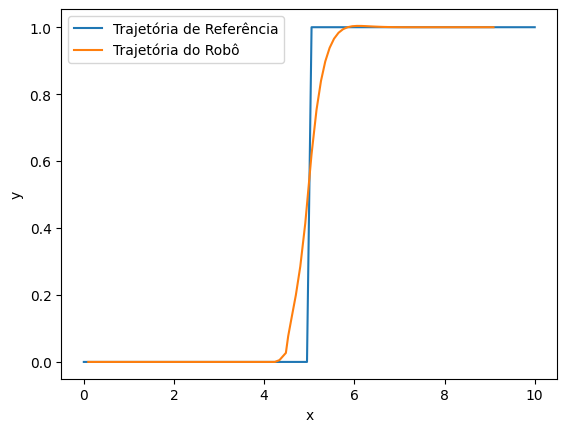

In [4]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt

class DifferentialDriveRobot:
    def __init__(self, R, L):
        self.R = R  # Raio da roda
        self.L = L  # Distância entre as rodas
        
        # Estados iniciais
        self.x = 0
        self.y = 0
        self.theta = 0

    def update(self, v_R, v_L, dt):
        v = (self.R / 2) * (v_R + v_L)
        omega = (self.R / self.L) * (v_R - v_L)
        
        self.x += v * np.cos(self.theta) * dt
        self.y += v * np.sin(self.theta) * dt
        self.theta += omega * dt

class MPCController:
    def __init__(self, robot, N, Q, R, dt):
        self.robot = robot
        self.N = N  # Horizonte de predição
        self.Q = Q  # Penalização para erro de rastreamento
        self.R = R  # Penalização para esforço de controle
        self.dt = dt  # Intervalo de tempo

    def solve(self, x_ref, y_ref):
        model = pyo.ConcreteModel()

        model.N = self.N
        model.dt = self.dt
        model.Q = self.Q
        model.R = self.R
        model.x_ref = x_ref
        model.y_ref = y_ref

        # Variáveis de otimização
        model.v_R = pyo.Var(range(model.N), domain=pyo.Reals)
        model.v_L = pyo.Var(range(model.N), domain=pyo.Reals)

        # Estados
        model.x = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.y = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.theta = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)

        # Estados iniciais
        model.x[0].fix(self.robot.x)
        model.y[0].fix(self.robot.y)
        model.theta[0].fix(self.robot.theta)

        # Função custo
        def objective_rule(model):
            cost = 0
            for t in range(model.N):
                cost += model.Q * ((model.x[t] - model.x_ref[t])**2 + (model.y[t] - model.y_ref[t])**2)
                cost += model.R * (model.v_R[t]**2 + model.v_L[t]**2)
            return cost
        
        model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Restrições de dinâmica
        model.dynamics = pyo.ConstraintList()
        for t in range(model.N):
            v = (self.robot.R / 2) * (model.v_R[t] + model.v_L[t])
            omega = (self.robot.R / self.robot.L) * (model.v_R[t] - model.v_L[t])
            model.dynamics.add(model.x[t+1] == model.x[t] + v * pyo.cos(model.theta[t]) * model.dt)
            model.dynamics.add(model.y[t+1] == model.y[t] + v * pyo.sin(model.theta[t]) * model.dt)
            model.dynamics.add(model.theta[t+1] == model.theta[t] + omega * model.dt)

        # Limites das variáveis de controle
        def control_limits_rule_R(model, t):
            return (-100, model.v_R[t], 100)
        
        def control_limits_rule_L(model, t):
            return (-100, model.v_L[t], 100)

        model.control_limits_R = pyo.Constraint(range(model.N), rule=control_limits_rule_R)
        model.control_limits_L = pyo.Constraint(range(model.N), rule=control_limits_rule_L)

        # Solver
        solver = SolverFactory('ipopt')
        result = solver.solve(model, tee=False)

        return model.v_R[0].value, model.v_L[0].value

# Parâmetros do robô
R = 0.1  # Raio da roda em metros
L = 0.5  # Distância entre as rodas em metros

# Criar instância do robô diferencial
robot = DifferentialDriveRobot(R, L)

# Criar instância do controlador MPC
mpc = MPCController(robot, N=10, Q=120, R=0.025, dt=0.1)

# Referência de trajetória
x_ref = np.linspace(0, 10, 100)  # Aumentar o número de pontos de referência
y_ref = np.sin(x_ref)
y_ref = 0.05 * x_ref**2
y_ref = np.sign(np.sin(2 * np.pi * 0.5 * x_ref))  # Frequência de 0.5 Hz
y_ref = np.piecewise(x_ref, [x_ref < 5, x_ref >= 5], [0, 1])

# Simulação
dt = 0.1
x_traj = []
y_traj = []
print('iniciando simulação')
for i in range(len(x_ref) - 10):  # Garantir que o loop seja executado
    v_R, v_L = mpc.solve(x_ref[i:i+10], y_ref[i:i+10])
    robot.update(v_R, v_L, dt)
    x_traj.append(robot.x)
    y_traj.append(robot.y)
    #print(f"Step {i}: x = {robot.x}, y = {robot.y}, theta = {robot.theta}, v_R = {v_R}, v_L = {v_L}")

# Plotar a trajetória
plt.plot(x_ref, y_ref, label='Trajetória de Referência')
plt.plot(x_traj, y_traj, label='Trajetória do Robô')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
